# Исследование

In [1]:
from IPython.display import HTML

import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

import seaborn as sns
import matplotlib.pyplot as plt

## Изучение данных

Далее представлено несколько колонок полученного набора данных.

Не нашел в репозитории описания данных, поэтому, опишу как я интерпретировал таблицу, для того чтобы читающему было понятнее по какой причине я принял те или иные решения.

Удельная запись представляест собой пары комбинаций пользователь-игра и соответсвнно описание пользовательского опыта в той или иной игре.

### Описание колонок

Очевидно что:

- `UserID` - уникальный идентификатор пользователя;
- `GameTitle` - уникальный идетификатор игры;
- `Age` - возраст пользователя;
- `Gender` - пол пользователя;
- `PurchaseHistory` - если история покупок у этого пользователя;
- `GameGenre` - жанр рассматриваемой игры;
- `GameUpdateFrequency` - как часто обновляется данная игра;
- `GameSettingsPreference` - некоторая особенность игры.

Для некоторых колонок не до конца понятно описывают они пользователя (одинаковые в рамках пользоваля), игру (одинаковые в рамках игры) или описывают выбранную комбинацию пользователь игра (то есть потенциально могут быть уникальными вне привязки к пользователю или игре).

Так например колонка `Rating` может описывать средний рейтинг по игре или быть отражением того, что так ее оценил пользователь который сопряжен с ней в этой записи.

Для того чтобы проверить такие моменты, для каждого пользователя/игры подсчитаем сколько уникальных значений соответсвуют ему в той или иной колонке. В следующей ячейке проводится эта процедура - в результате для каждой колонки поставлено в соответсвие уникальные ли в ней значения по пользователю и по игре.

In [3]:
display(HTML("<b>По пользователю</b>"))
by_user = (
    (data.groupby("UserID").nunique() == 1)
    .all().replace({True:"Уникальное", False:"Не уникальное"})
)
by_game = (
    (data.groupby("GameTitle").nunique() == 1)
    .all().replace({True:"Уникальное", False:"Не уникальное"})
)
pd.DataFrame({
    "По пользователю" : by_user,
    "По игре" : by_game
}).loc[data.columns]

,По пользователю,По игре
UserID,NaN,Не уникальное
GameTitle,Не уникальное,NaN
Rating,Не уникальное,Не уникальное
Age,Уникальное,Не уникальное
Gender,Уникальное,Не уникальное
Location,Уникальное,Не уникальное
Device,Уникальное,Не уникальное
PlayTimeOfDay,Уникальное,Не уникальное
TotalPlaytimeInHours,Уникальное,Не уникальное
PurchaseHistory,Уникальное,Не уникальное


Можно сделать выводы про следующие колонки:

- `Rating` указывает как клиент из записи оценил соовтевующую игру;
- `Location` указывает на условно постоянный адрес пользоватля (а не то куда он играл в ту или иную игру);
- `Device` указывает на условно постоянный девайс пользователя (а не то каой девайс он исопльзовал для игры);
- `PlayTimeOfDay` указывает когда клиент предпочитает играть - уникальный по пользователю;
- `TotalPlaytimeInHours` то сколько **всего** играл пользователь во все игры, а не то соколько он играл именно в эту игру;
- `InvolvementLevel` - то насколько пользователь вовлечен в игровую платформу в целом а не в конкретную игру;
- `UserReview` - отзыв пользователя, видимо ко всей платформе в целом а не к конкретной игре;
- `SocialActivity` - не до конца понятно что это за колонка но это какая-то уникальная характеристика игры;
- `LoadingTimeInSeconds` - сколько данная игра загружалась, получается что у всех пользователей игра зпускается одинаково быстро.

**Целевая переменная**

Совершенно очевидно, что в данном случае следует использовать переменную `Rating` как целевую переменную (target) так как только она характеризует некотрое свойсво комбинации пользователь/игра, Все остальные переменны характеризую либо некоторого пользователя либо некоторую игру.

## Гипотезы

### Соряженность свойсв игры/пользователя

Возможно женщинам и мужчинам нравятся разные игровые жанры. Поэтому подсчитаем раличные статистики по рейтингу в сопряженности пола и игрового жанра.

In [4]:
my_gb = data.groupby(["Gender", "GameGenre"])

display(HTML("<b style='font-size: 14px'>Количество наблюдений</b>"))
display(my_gb["Rating"].count().unstack())
display(HTML("<b style='font-size: 14px'>Средний рейтинг</b>"))
display(my_gb["Rating"].mean().unstack())
display(HTML("<b style='font-size: 14px'>Доля наблюдений с рейтингом 5</b>"))
display(my_gb["Rating"].apply(lambda sub_col: (sub_col > 4).mean()).unstack())

GameGenre,Action,Adventure,Puzzle,RPG,Simulation,Sports,Strategy
Gender,,,,,,,
Female,2920,4015,1460,2555,2555,3650,1095
Male,2520,3465,1260,2205,2205,3150,945
Other,2560,3520,1280,2240,2240,3200,960


GameGenre,Action,Adventure,Puzzle,RPG,Simulation,Sports,Strategy
Gender,,,,,,,
Female,2.994178,3.037360,2.939041,2.971820,3.008611,3.003288,3.044749
Male,2.994841,2.990765,2.949206,3.013605,3.016780,2.984444,3.082540
Other,3.010937,3.001705,3.013281,2.973214,3.008482,2.992812,2.984375


GameGenre,Action,Adventure,Puzzle,RPG,Simulation,Sports,Strategy
Gender,,,,,,,
Female,0.198630,0.201743,0.192466,0.199609,0.199217,0.200548,0.207306
Male,0.194444,0.194228,0.184921,0.200000,0.205896,0.193968,0.220106
Other,0.202734,0.203693,0.204687,0.194643,0.209375,0.194062,0.194792


Можно подумать, что мобильные платформы не такие производительные как стационарные поэтому стоит перепроверить может не стоит на мобилы рекомендовать высокопроизводительные игры. Закономерностей не обнаружено.  

In [5]:
my_gb = data.groupby(["GameSettingsPreference", "Device"])

display(HTML("<b style='font-size: 14px'>Количество наблюдений</b>"))
display(my_gb["Rating"].count().unstack())
display(HTML("<b style='font-size: 14px'>Средний рейтинг</b>"))
display(my_gb["Rating"].mean().unstack())
display(HTML("<b style='font-size: 14px'>Доля наблюдений с рейтингом 5</b>"))
display(my_gb["Rating"].apply(lambda sub_col: (sub_col > 4).mean()).unstack())

Device,Console,Mobile,PC
GameSettingsPreference,,,
Balanced,3924,4032,4044
High Graphics,7194,7392,7414
High Performance,5232,5376,5392


Device,Console,Mobile,PC
GameSettingsPreference,,,
Balanced,2.994139,3.001984,3.010386
High Graphics,2.981790,3.021645,3.004181
High Performance,2.959098,2.989955,3.036165


Device,Console,Mobile,PC
GameSettingsPreference,,,
Balanced,0.200306,0.200893,0.199060
High Graphics,0.194746,0.202922,0.197194
High Performance,0.189220,0.201079,0.210497


### Решающее дерево

Предположения опирающиеся на бизнес смысл переменных не дают никакого результата. Пойдем от обратного. Попробуем построить простенькую, легко интерпретируемую модельку и посмотрим на результат. Возьмем, например, не глубокое решающее дерево и попробуем из его решений выловить закономерности. В следующей ячейке подогнано и визуализировано решающее дерево. Похоже, анализ среднего рейтинга нидает никакого внятного результата.

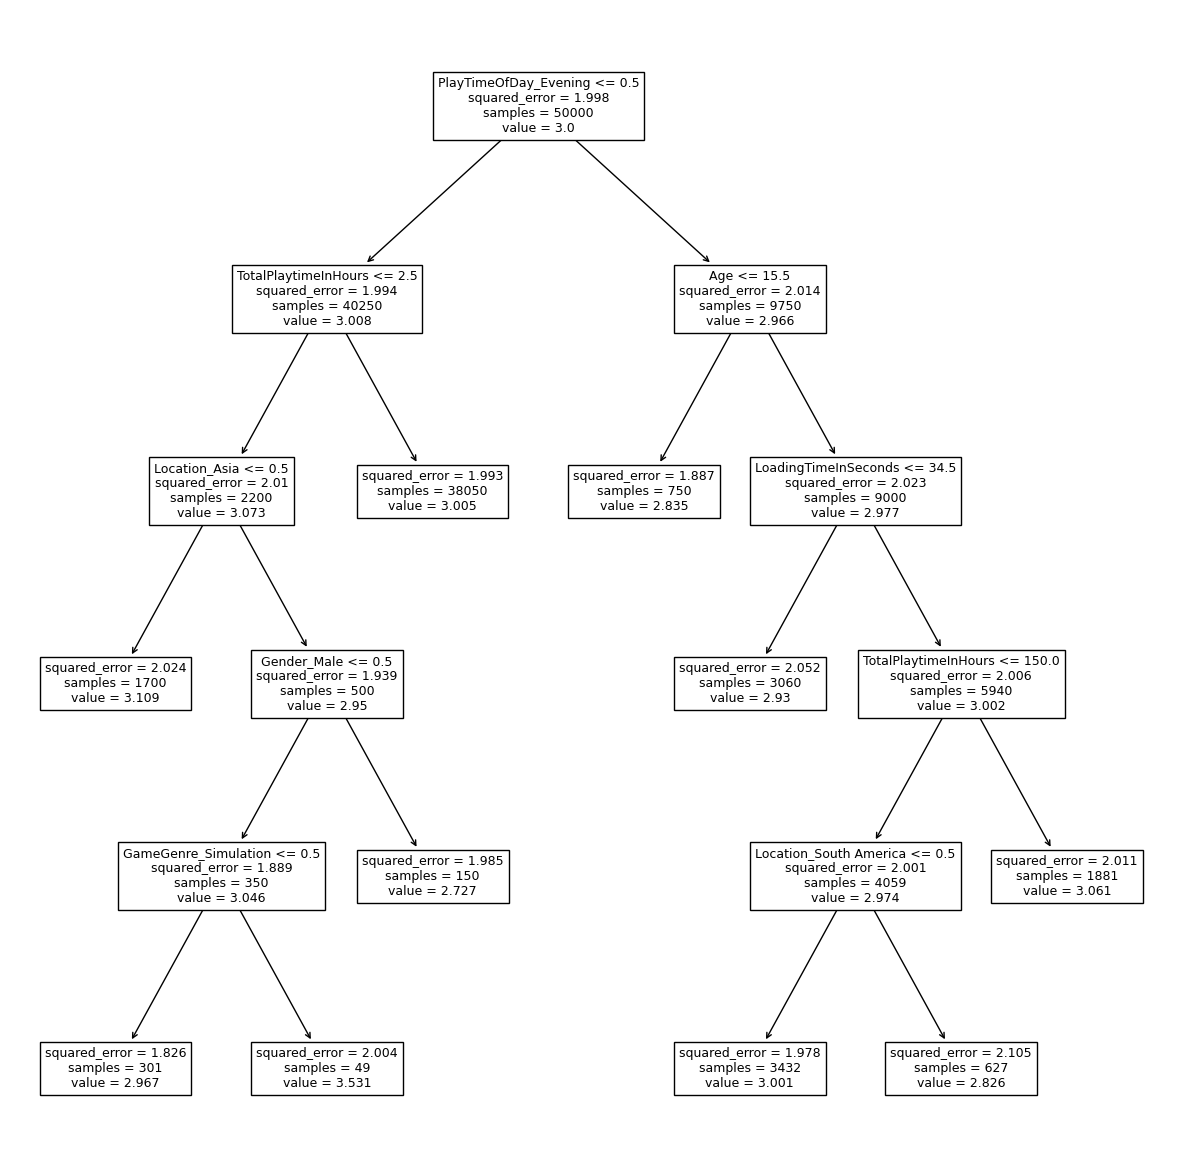

In [6]:
X = data.drop(["UserID", "GameTitle", "Rating"], axis = 1)
X = pd.get_dummies(X, drop_first=True)
y = data["Rating"]

clf = tree.DecisionTreeRegressor(max_leaf_nodes = 10)
clf.fit(X, y)

plt.figure(figsize = [15,15])
tree.plot_tree(clf, feature_names=X.columns)
plt.show()

### Предпочтения пользователя

Предположим, пользователь играет не первый день (выборка это допускает). Тогда, ему рационально подсовывать игры похожие на те которые раньше он оценивал хорошо.

В кочестве примера того, что я имею ввиду рассмотрим средние рейтинги каждого пользователя играм по требованиям игры. Далее представлено как игры разной требовательности в среднем оценивали первый и второй пользователи. Видно, что первый пользователь предпочитает игры которые шустро запускаются на его устройсве. А второй любит игры в которых красивая графика. Так же в контесте именно этой переменной, стоит обратить внимание, что "Balanced" игры занимают промежуточное состояние.

In [38]:
data.groupby(
    ["GameSettingsPreference", "UserID"]
)["Rating"].mean().unstack().loc[
    ["High Graphics", "Balanced", "High Performance"]
][["user_1", "user_2"]]

UserID,user_1,user_2
GameSettingsPreference,,
High Graphics,2.772727,3.227273
Balanced,3.083333,3.166667
High Performance,3.500000,2.312500


Теперь, попробуем каждому пользователю поставить в сооветсвие тот `GameSettingsPreference` который ему наилучшим образом подходит - получится уже некоторая характеритика пользователя. Поставим в сооветсвие предпочтениям пользователя относительно производительностей игр в которые он играл производетельности игр которые мы потенциально можем ему рекомендовать. 

In [82]:
temp = data.copy()

u_GameSettingsPreference = data.groupby(["UserID"])[[
    "GameSettingsPreference",
    "Rating"
]].apply(
    lambda sub:
        sub.groupby("GameSettingsPreference")["Rating"].mean().idxmax()
)
u_GameSettingsPreference.name = "u_GameSettingsPreference"
temp = pd.merge(
    temp,
    user_favorite_performance,
    left_on="UserID",
    right_index=True
)

my_gb = temp.groupby(["u_GameSettingsPreference", "GameSettingsPreference"])

display(HTML("<b style='font-size: 14px'>Количество наблюдений</b>"))
display(my_gb["Rating"].count().unstack())
display(HTML("<b style='font-size: 14px'>Средний рейтинг</b>"))
display(my_gb["Rating"].mean().unstack())
display(HTML("<b style='font-size: 14px'>Доля наблюдений с рейтингом 5</b>"))
display(my_gb["Rating"].apply(lambda sub_col: (sub_col > 4).mean()).unstack())

GameSettingsPreference,Balanced,High Graphics,High Performance
u_GameSettingsPreference,,,
Balanced,4164,7634,5552
High Graphics,3912,7172,5216
High Performance,3924,7194,5232


GameSettingsPreference,Balanced,High Graphics,High Performance
u_GameSettingsPreference,,,
Balanced,3.367915,2.903589,2.864733
High Graphics,2.747188,3.231177,2.801572
High Performance,2.868502,2.880178,3.327408


GameSettingsPreference,Balanced,High Graphics,High Performance
u_GameSettingsPreference,,,
Balanced,0.272574,0.178150,0.178134
High Graphics,0.152352,0.246375,0.151265
High Performance,0.170744,0.171810,0.272936


На гланых диоганалях некоторых из табличек наметился некоторый рост статистик описывающих шанс того что пользователь поставит статистику той или иной игре повыше. Уже что-то, но, конечно, такой подход серьезно подвержен переобучению, поэтому оценка наиболее предпочтительных свойств игр для пользователя должна производится на тестовой выборке.

## Выбор переменных

In [7]:
data.select_dtypes("number").describe()

,Rating,Age,TotalPlaytimeInHours,LoadingTimeInSeconds
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,3.000280,40.059000,96.810000,53.480000
std,1.413591,17.501418,93.622771,30.114245
min,1.000000,10.000000,1.000000,11.000000
25%,2.000000,25.000000,11.000000,30.000000
50%,3.000000,40.000000,50.000000,51.000000
75%,4.000000,55.000000,177.000000,76.000000
max,5.000000,70.000000,299.000000,117.000000


In [8]:
data.select_dtypes("O").describe()

,UserID,GameTitle,Gender,Location,Device,PlayTimeOfDay,PurchaseHistory,InvolvementLevel,UserReview,GameGenre,GameUpdateFrequency,SocialActivity,GameSettingsPreference
count,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000,50000
unique,1000,50,3,6,3,4,2,4,3,7,3,3,3
top,user_1000,game_1,Female,South America,PC,Night,No,Expert,Positive,Adventure,Occasional,Active,High Graphics
freq,50,1000,18250,9100,16850,19450,34600,13300,17600,11000,18000,22000,22000


## Контентный подход

In [60]:
model = CatBoostRegressor(
    cat_features=X.select_dtypes("O").columns.to_list(),
    random_state=11,
    silent = True
).fit(X_train, y_train)

In [62]:
predict_test = pd.Series(model.predict(X_test), index=X_test.index)
predict_train = pd.Series(model.predict(X_train), index=X_train.index)

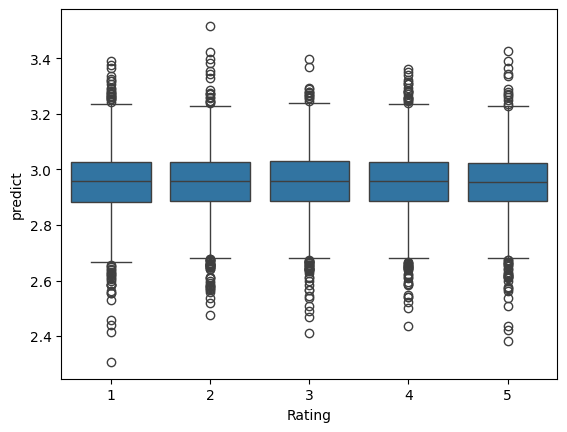

In [63]:
temp = data.loc[X_test.index, ["UserID", "GameTitle", "Rating"]]
temp["predict"] = predict_test

sns.boxplot(
    data = temp,
    x = "Rating",
    y = "predict"
)

del temp

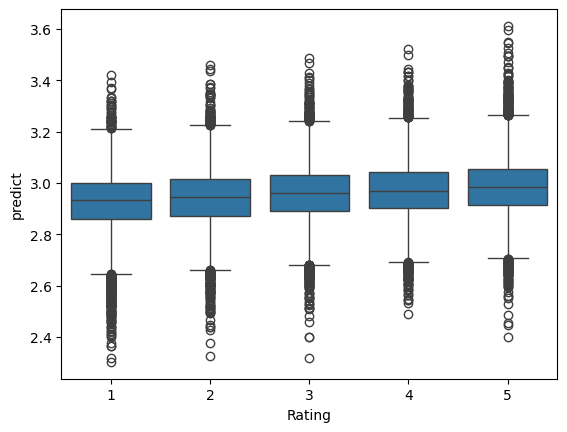

In [65]:
temp = data.loc[X_train.index, ["UserID", "GameTitle", "Rating"]]
temp["predict"] = predict_train

sns.boxplot(
    data = temp,
    x = "Rating",
    y = "predict"
)

del temp